In [1]:
%load_ext autoreload
%autoreload 2

### Comparison with random path

<div class="alert alert-block alert-info">

The transition matrix's $P$ left eigenvector with eigenvalue 1 (i.e. $x$ such that $xP=x$) is called the steady-state of the system. Let's call the normalised vector $x = (x_1, x_2, \dots, x_N)$, where the sum of all $x_i$ is 1. After $\infty$ iterations, starting from whatever article, the probability distribution of the end article is given by $x$. 

**Example**: For 3 articles, let's say that we have $x=(0.2, 0.3, 0.5)$. Then, when starting from any of the articles and taking infinitely many steps, there is probability 0.2 to be in article 1, probability 0.3 to be in article 2 and probability 0.5 to be in article 3.

</div>

In [ ]:
# compare with and without back-clicks
val, vec = np.linalg.eig(markov_transitions.T)
ss = np.real(-vec[:, 0]) / np.real(-vec[:, 0]).sum()
top_indices = np.argsort(ss)[-20:][::-1]
df_article_names.iloc[top_indices]

<div class="alert alert-block alert-success">
There is indeed a vector with eigenvalue one, so there is a steady state in the system. To find the probabilities to be in a certain article in the steady state, we can look at the normalised values of the eigenvector. We see that United States is the most likely article to be in, followed mainly by a bunch of other countries.
</div>

<div class="alert alert-block alert-info">

#### Compare user vs random

Let's start in any article $i$ and take $l$ steps in the network, which leads to article $j$. The probability of this happening by chance in the network is simply $P_{ij}(l)=A^l_{ij}$. To get probabilities of transitions for every pair of articles and path length $l$, we only need to take the $l$-th power of the transition matrix! This effectively characterises the bias of the network itself: if users pass by an article A very often BUT that only by chance you end up on the same article often too, we cannot conclude that the user made that choice. 

To characterise the user choices, we simply take the paths they created by playing. We can then similarly create a transition matrix based on observed data: just take the aggregated count of all the transitions from all starting articles. For instance, from article $i$ we count 2 transitions to article $j_1$, 3 to $j_2$ and none to $j_3$. The normalised transition probabilities for article $i$ are then $(0.4, 0.6, 0)$. 

The difference in transition probabilities $\Delta P=(0.4, 0.6, 0) - (0.2, 0.3, 0.5) = (0.2, 0.3, -0.5) \in [-1, 1]^3$ then gives an idea of how likely it is that a user purposedly made a choice and not only ended in an article by accident. A highly positive value means that even though the transition is very unlikely in the network, the user made that choice. A larger negative value means that a user took a path that is rather unlikely under the random walk assumption. The Markov Chain allows to filter out the network bias in the user decisions.

<b>Note:</b> Maybe look into odds instead of probabilities to be more rigorous? https://stats.stackexchange.com/questions/22796/compare-the-difference-of-two-probabilities-or-a-ratio-of-probabilities

</div>

In [ ]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
user_transitions = get_nth_transition_matrix(df_finished, df_article_names, 1)

print(f'Non-zero values of random transitions: {np.count_nonzero(markov_transitions)}')
print(f'Non-zero values of user transitions: {np.count_nonzero(user_transitions.to_numpy())}')


In [ ]:
#TODO: replace with markov, regrouper par categories comme plot avant
#TODO: plot camille position page structure

In [2]:
from src.models.markov_chains import *
from src.utils.HTMLParser import HTMLParser
from src.utils.helpers import *
from src.data.data_loader import *
import pandas as pd
import matplotlib.colors as mcolors
import plotly.express as px
import numpy as np

parser = HTMLParser()
parser.load_pickle()

In [3]:
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_sm, df_scat, df_article = read_all()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Black ops 2', 'Podcast', 'Western Australia', 'Usa', 'Netbook', 'Christmas', 'English', 'Fats', 'Pikachu', 'Rss', 'Macedonia', 'Test', 'The', 'Long peper', 'Great', 'Charlottes web', 'Sportacus', 'Georgia', 'Rat', 'Mustard', ' Zebra', 'The Rock', 'Bogota', 'Adolph Hitler', 'Kashmir'}
Invalid articles found in path: {'Pikachu', 'Private Peaceful', 'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License', 'Local community'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24709 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Local community', 'Pikachu', 'Wikipedia Text of the GNU Free Documentation License', 'Osteomalacia'}
Number of rows after filtering: 51196
df_article_names length: 4584
df_links length (unique linkTarget): 4128
df_links length (unique linkS

In [4]:
voyage_categories = ['Geography of Great Britain', 'Geography of Asia', 'Geography of Oceania Australasia', 'North American Geography', 'European Geography', 'African Geography', 'Central and South American Geography', 'Antarctica', 'Geography of the Middle East', 'African Countries', 'Countries']
df_categories_filtered = filter_most_specific_category(df_categories)
df_categories_filtered = voyages_categories(df_categories_filtered, voyage_categories)
df_categories_filtered[df_categories_filtered['level_1']!='Voyages']

,article,category,level_1,level_2,level_3
0,Constructivism (art),Art.Art,Art,Art,None
1,Drama,Art.Art,Art,Art,None
2,Drawing,Art.Art,Art,Art,None
3,Expressionism,Art.Art,Art,Art,None
4,History of painting,Art.Art,Art,Art,None
...,...,...,...,...,...
4579,47 Ursae Majoris b,Science.Physics.Space Astronomy,Science,Physics,Space Astronomy
4580,African Brush-tailed Porcupine,Science.Biology.Mammals,Science,Biology,Mammals
4581,47 Ursae Majoris c,Science.Physics.Space Astronomy,Science,Physics,Space Astronomy
4582,Aberration of light,Science.Physics.General Physics,Science,Physics,General Physics


In [5]:
df_categories_filtered['level_1'].unique()


array(['Art', 'Mathematics', 'IT', 'Business Studies', 'Music',
       'Religion', 'Language and literature', 'Citizenship', 'Voyages',
       'Design and Technology', 'Everyday life', 'History', 'People',
       'Geography', 'Science'], dtype=object)

In [6]:
df_paths = pd.concat([df_finished[['path', 'path_length']], df_unfinished[['path', 'path_length']]])

In [7]:
categories_others = df_categories_filtered['level_1'].unique().tolist() + ['Others']

# colors for country and geo 
highlight_colors = {'Voyages': '#2CB5AE'}

# shades of grey for other categories
num_greys = len(categories_others) - 1  # num of categories - country and geo 
grey_shades = [mcolors.to_hex((v, v, v)) for v in np.linspace(0.2, 0.4, num_greys)]
non_custom_categories = [cat for cat in categories_others if cat not in highlight_colors]
grey_palette = dict(zip(non_custom_categories, grey_shades)) 

# Combine custom colors and grey palette : final category palette
palette_category_dict = {**highlight_colors, **grey_palette}

In [8]:
highlight_colors = {'Voyages': '#2CB5AE'}
categories_others = df_categories_filtered['level_1'].unique().tolist() + ['Others']
num_greys = len(categories_others) - 1
grey_shades = [mcolors.to_hex((v, v, v)) for v in np.linspace(0.2, 0.4, num_greys)]
non_custom_categories = [cat for cat in categories_others if cat not in highlight_colors]
grey_palette = dict(zip(non_custom_categories, grey_shades))
palette_category_dict = {**highlight_colors, **grey_palette}

article_to_color_dict = {}
for _, row in df_categories_filtered.iterrows():
    article = row['article']
    category = row['level_1']
    article_to_color_dict[article] = palette_category_dict.get(category, '#808080')

In [9]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
user_transitions = get_nth_transition_matrix(df_finished, df_article_names, 1)

print(f'Non-zero values of random transitions: {np.count_nonzero(markov_transitions)}')
print(f'Non-zero values of user transitions: {np.count_nonzero(user_transitions.to_numpy())}')

Non-zero values of random transitions: 119855
Non-zero values of user transitions: 25151


In [10]:
diff = user_transitions-markov_transitions
mean_diff_indegree = diff.sum(axis=0).sort_values(ascending=False)
mean_diff_indegree

article
United States                219.681123
Europe                       100.233262
England                       95.131996
United Kingdom                69.586810
World War II                  40.748234
                                ...    
Animal                       -10.015920
Carolus Linnaeus             -10.290777
Binomial nomenclature        -18.524412
Chordate                     -19.782002
Scientific classification    -21.930998
Length: 4584, dtype: float64

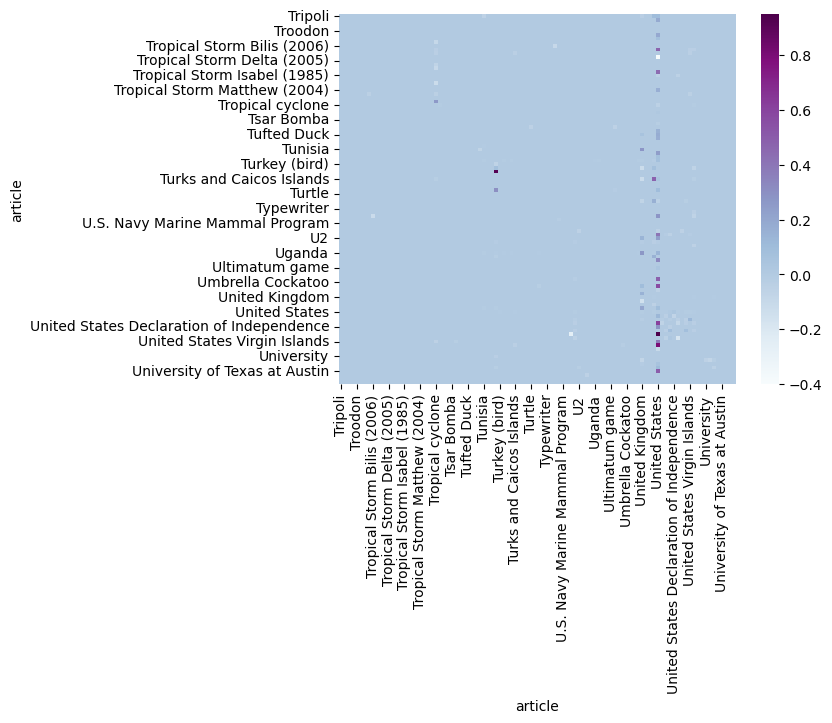

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(diff.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.show()

In [13]:
KL = np.where((user_transitions > 0) & (markov_transitions > 0), user_transitions * np.log(user_transitions / markov_transitions), 0)
KL_df = pd.DataFrame(KL, columns=user_transitions.columns, index=user_transitions.index)
mean_KL = KL_df.sum(axis=0).sort_values(ascending=False)
mean_KL

c:\Users\yanni\.conda\envs\ada_project\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


article
United States           580.752776
Europe                  276.440782
England                 254.826100
United Kingdom          202.655357
World War II            126.872270
                           ...    
GNOME                    -0.265180
Abhidhamma Pitaka        -0.270310
The Supremes             -0.295799
Wikimedia Foundation     -0.329321
Action potential         -0.347136
Length: 4584, dtype: float64

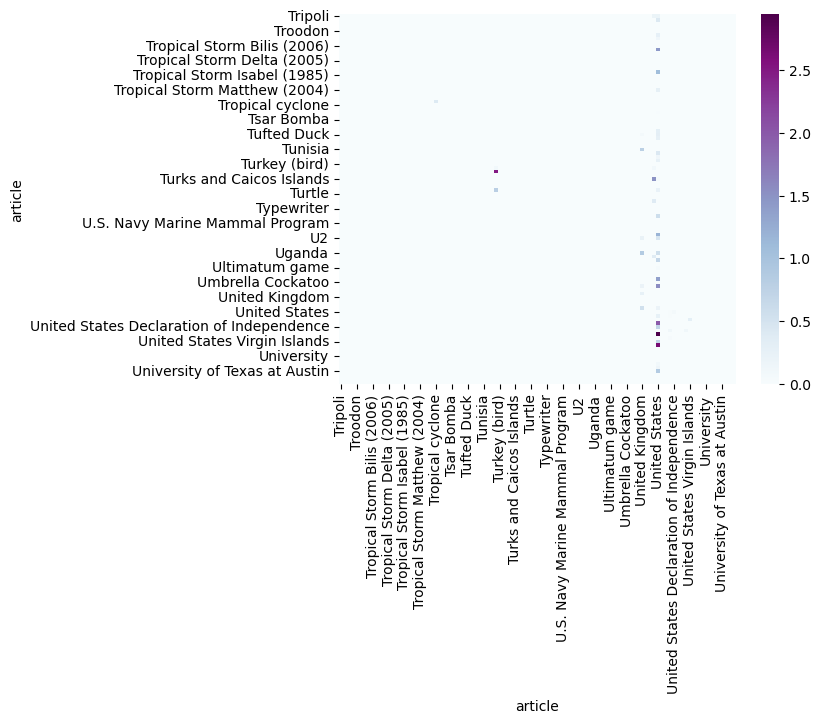

In [14]:
sn.heatmap(KL_df.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.show()

<div class="alert alert-block alert-success">

For the first transition, much more users go to United States or Europe than only following random transitions would.

<b>Notes:</b> 
- Values close to 0 means it is close to random behaviour. Values that are closer to -1 or 1 are the special behaviour, either clicking much more or much less on certain articles than random would predict.
- How could we remove the link position bias? Maybe check if certain links are on the top/bottom of the page and give more or less importance accordingly?
- Does adding backclicks as in the function above make sense?
</div>

## How does user's deviation from random path evolve during games ?


<div class="alert alert-block alert-success">

We can look at the difference between user games and random games at different steps of the game. This highlights the evolution of which articles palyers **voluntarily chose** to visit at different stages of the game. 
</div>

In [15]:
%%capture
mean_diff_step, mean_KL_step = get_step_divergences(df_article_names, parser, df_paths)

In [33]:
main_mean_div = mean_KL_step.iloc[:, :10]
plot_article_step_divergence(main_mean_div, article_to_color_dict)

### What about the evolution of categories ?

In [17]:
plot_category_step_divergence(mean_KL_step, df_categories_filtered, palette_category_dict)

In [18]:
#TODO add a measure of variance as shaded region around your main line

In [40]:
P = np.array([[0.2, 0.8], [0.6, 0.4]])
Q = np.array([[0.1, 0.9], [0.3, 0.7]])
KL = np.where((P > 0) & (Q > 0), P * np.log(P / Q), 0)
KL.sum(axis=0)

array([ 0.55451774, -0.31807274])

<div class="alert alert-block alert-success">
The Countries and Geography categories have similar behaviors, having extreme values, both strongly positive values for the first transition (~200 and 70 respectively), and strongly negative values in later steps (between -500 and -1000 and between -350 and -550 respectively).

- The stronly positive values for the first transition shows strong evidence that the first click of players are voluntarily directed towards Countries and Geography articles.

- The strong negative values for following steps shows strong evidence that folowing the first clicks, players voluntarily direct their click towards other categories.  

Further study of the evolution of country and geography articles is needed to explore where those strong values come from.

Let's look at articles of the Countries category more specifically:
</div>

<div class="alert alert-block alert-success">
Interestingly, no strongly negative values appear in later steps. This indicates that the strong negative values in the category plot is likely due to the accumulation of many small negative deviation from the random path. 

Lets verify this assimption by grouping articles that stay close to the random path as 'Others' article, and plotting their mean, and the value of their sum. 
</div>

<div class="alert alert-block alert-success">
A great majority of countries articles are clicked close to randomly (the difference between player path and random path is close to 0), but they are so numerous that they cumulate to be very significant in the country category.

These articles being so influent in the category stats and being close to random, we could make the choice to ingore them by :
finding a way for them not to influence so much the category: by removing them? by expressing them under 'Other_mean'? how to justify this choice? 
</div>

## Small Example

In [19]:
example_articles = pd.Series(['United States', 'France', 'Agriculture', 'Mexico', 'Natural gas'])

tp = get_transition_probabilities(example_articles, parser, backclicks=True)

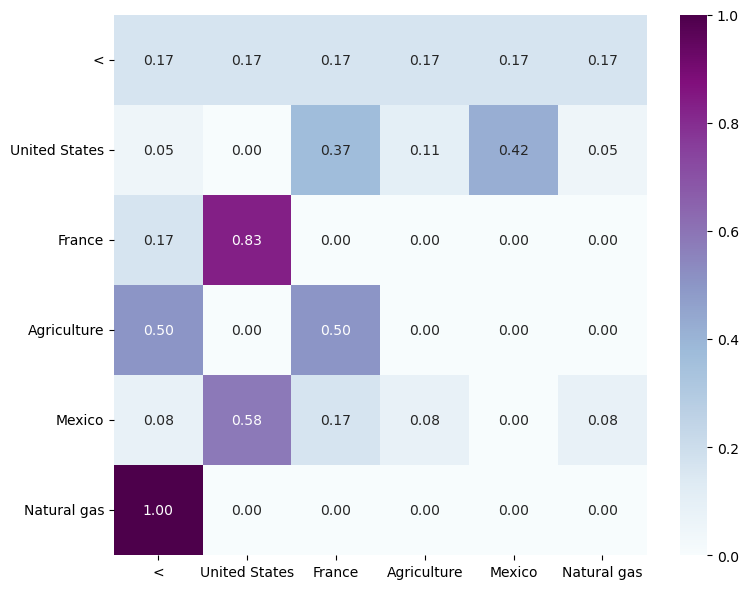

In [20]:
plt.figure(figsize=(8, 6))
sn.heatmap(np.linalg.matrix_power(tp, 1), cmap='BuPu', annot=True, fmt=".2f", cbar=True)

plt.xticks(np.arange(6) + 0.5, ['<'] + example_articles.to_list(), rotation=0)  # Keep x-ticks horizontal
plt.yticks(np.arange(6) + 0.5, ['<'] + example_articles.to_list(), rotation=0)  # Make y-ticks horizontal

plt.tight_layout()
plt.show()

In [21]:
eigval, eigvec = np.linalg.eig(tp.T)
steady_state = eigvec[:, 0] / np.sum(eigvec[:, 0])
print(np.isclose(steady_state @ tp, steady_state)) # testing if the vector is really a left eigenvector with eigenvalue 1

[ True  True  True  True  True  True]


In [22]:
steady_state # 0.19% end up in "<", 0.29% in "United States", ...

array([0.19663573, 0.29825261, 0.20772912, 0.07736369, 0.15835267,
       0.06166618])

In [23]:
example_articles = pd.Series(['United States', 'France', 'Agriculture', 'Mexico'])
markov_example = get_transition_probabilities(example_articles, parser, backclicks=False)
user_example = row_normalise(user_transitions[example_articles].loc[example_articles])
diff_example = user_example-markov_example

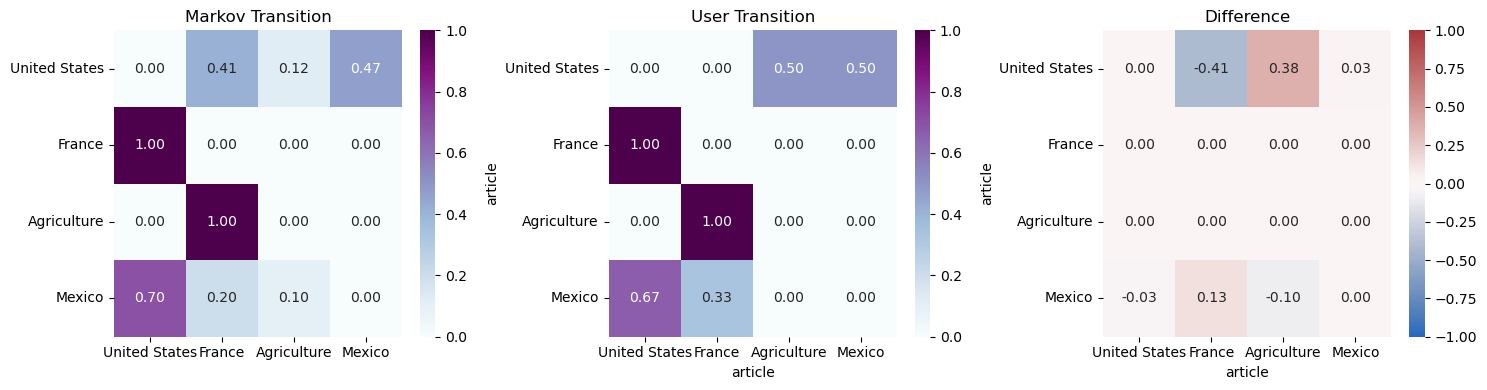

In [24]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
sn.heatmap(markov_example, cmap='BuPu', annot=True, fmt=".2f", cbar=True, vmin=0, vmax=1)
plt.xticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Keep x-ticks horizontal
plt.yticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Make y-ticks horizontal
plt.title('Markov Transition')

plt.subplot(132)
sn.heatmap(user_example, cmap='BuPu', annot=True, fmt=".2f", cbar=True, vmin=0, vmax=1)
plt.xticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Keep x-ticks horizontal
plt.yticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Make y-ticks horizontal
plt.title('User Transition')

plt.subplot(133)
sn.heatmap(diff_example, cmap='vlag', annot=True, fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.xticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Keep x-ticks horizontal
plt.yticks(np.arange(4) + 0.5, example_articles.to_list(), rotation=0)  # Make y-ticks horizontal
plt.title('Difference')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

For France and Agriculture, the Markov Chain perfectly aligns with the observations. For Mexico, it is a very close match, slightly more people than random go to France and slightly less to Agriculture and United States. For United States, many more people went to Agriculture than predicted and less to France.
</div>

### Categories normalised by transition probabilities

In [26]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False, normalise=False)

In [27]:
from src.utils.helpers import map_path_to_categories
article_to_category = dict(zip(df_categories['article'], df_categories['level_1']))
mapped_categories = map_path_to_categories(df_article_names, article_to_category)

In [28]:
transitions_per_category = pd.DataFrame({'category': mapped_categories, 'transition': markov_transitions.sum(axis=1)})
transitions_per_category=transitions_per_category.groupby('category', as_index=False).sum()
transitions_per_category

,category,transition
0,Art,1352.0
1,Business Studies,3217.0
2,Citizenship,9227.0
3,Countries,23090.0
4,Design and Technology,5533.0
5,Everyday life,10700.0
6,Geography,31885.0
7,History,19845.0
8,IT,1350.0
9,Language and literature,5518.0


In [29]:
from collections import Counter

category_counts = Counter(mapped_categories)
# Convert to a DataFrame if needed
category_counts_df = pd.DataFrame(category_counts.items(), columns=['category', 'count'])


In [30]:
result = pd.merge(category_counts_df , transitions_per_category, on='category')
result['ratio'] = result['count'] / result['transition']
result=result.sort_values(by='ratio')

C:\Users\yanni\AppData\Local\Temp\ipykernel_45684\4165116778.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




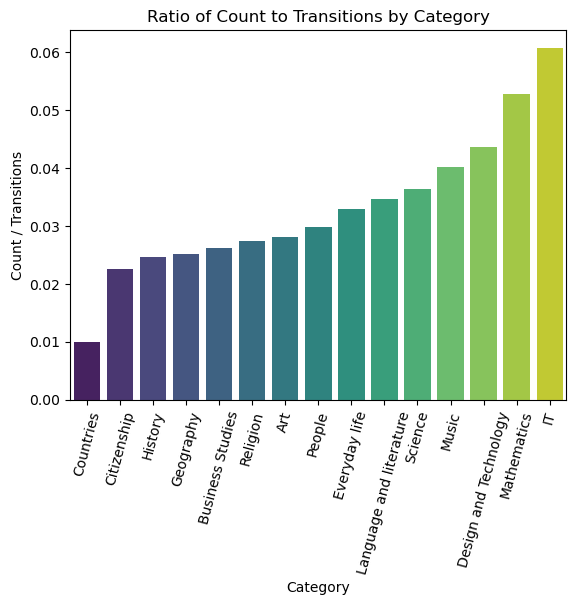

In [31]:
#TODO: adapt plot to colors and categories chosen

sn.barplot(data=result, x='category', y='ratio', palette='viridis')

# Customize the plot
plt.xlabel('Category')
plt.ylabel('Count / Transitions')
plt.title('Ratio of Count to Transitions by Category')
plt.xticks(rotation=75) 
plt.show()

In [32]:
import numpy as np

# Example matrices
P_user = np.array([[0.7, 0.3], [0.4, 0.6]])
P_random = np.array([[0.5, 0.5], [0.5, 0.5]])
print(f'user:\n{P_user}')
print(f'rand:\n{P_random}')

KL_matrix = np.where(P_user > 0, P_user * np.log(P_user / P_random), 0)

print("Element-wise KL Divergence Matrix:")
print(KL_matrix)


user:
[[0.7 0.3]
 [0.4 0.6]]
rand:
[[0.5 0.5]
 [0.5 0.5]]
Element-wise KL Divergence Matrix:
[[ 0.23553057 -0.15324769]
 [-0.08925742  0.10939293]]
